In [1]:
import os

import numpy as np
import torch
from torch.utils.data import DataLoader

# import Dataset from dataloader.py
from dataloader import VideoAudioDataset, ResamplingSampler, VATransform

# !! Put data file location in file `data_filepath`
# If file `data_filepath` does not exist, assume data is located in root
filepath = 'vis-data-256/vis-data-256/'

if os.path.isfile('data_filepath'):
    with open('data_filepath', 'r') as f:
        filepath = f.readline() + filepath

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
print(device)


cuda


# Model Example

In [4]:
from models import VideoAudioMatchingModel2

model = VideoAudioMatchingModel2().to(device)

c:\Users\gioef\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\gioef\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2Model: ['lm_head.bias', 'lm_head.weight']
- This IS expected if you are initializing Wav2Vec2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a Bert

In [5]:
from torchsummary import summary

summary(model)

Layer (type:depth-idx)                                  Param #
├─VideoResNet: 1-1                                      --
|    └─BasicStem: 2-1                                   --
|    |    └─Conv3d: 3-1                                 28,224
|    |    └─BatchNorm3d: 3-2                            128
|    |    └─ReLU: 3-3                                   --
|    └─Sequential: 2-2                                  --
|    |    └─BasicBlock: 3-4                             221,440
|    |    └─BasicBlock: 3-5                             221,440
|    └─Sequential: 2-3                                  --
|    |    └─BasicBlock: 3-6                             672,512
|    |    └─BasicBlock: 3-7                             885,248
|    └─Sequential: 2-4                                  --
|    |    └─BasicBlock: 3-8                             2,688,512
|    |    └─BasicBlock: 3-9                             3,539,968
|    └─Sequential: 2-5                                  --
|    |    └─

Layer (type:depth-idx)                                  Param #
├─VideoResNet: 1-1                                      --
|    └─BasicStem: 2-1                                   --
|    |    └─Conv3d: 3-1                                 28,224
|    |    └─BatchNorm3d: 3-2                            128
|    |    └─ReLU: 3-3                                   --
|    └─Sequential: 2-2                                  --
|    |    └─BasicBlock: 3-4                             221,440
|    |    └─BasicBlock: 3-5                             221,440
|    └─Sequential: 2-3                                  --
|    |    └─BasicBlock: 3-6                             672,512
|    |    └─BasicBlock: 3-7                             885,248
|    └─Sequential: 2-4                                  --
|    |    └─BasicBlock: 3-8                             2,688,512
|    |    └─BasicBlock: 3-9                             3,539,968
|    └─Sequential: 2-5                                  --
|    |    └─

In [5]:
video, audio, label = dataset[0]
video = video.unsqueeze(0)
audio = audio.unsqueeze(0)
video = video.to(device)
audio = audio.to(device)

In [6]:
video.shape, audio.shape

(torch.Size([1, 3, 3, 52, 92]), torch.Size([1, 48000]))

# Training Loop

In [6]:
train_dataset = np.load('datasets/train_dataset.npy')
# remove 2015-09-12-04-15-35-1_mic.wav row
train_dataset = train_dataset[train_dataset[:, 1] != '2015-09-12-04-15-35-1_mic.wav']

val_dataset = np.load('datasets/val_dataset.npy')
test_dataset = np.load('datasets/test_dataset.npy')

transforms = [VATransform.RANDOM_SEGMENT, 
                    VATransform.IMG_DOWNSAMPLE,
                    VATransform.FRAME_DOWNSAMPLE,
                    VATransform.DATA_AUGMENT]


transform_args = {'random_segment_seconds': 1, 'frame_downsample_factor': 4, 'img_downsample_factor': 4}

train_dataset_cls = VideoAudioDataset(train_dataset, device, filepath_prefix=filepath, transform=transforms, **transform_args)
val_dataset_cls = VideoAudioDataset(val_dataset, device, filepath_prefix=filepath, transform=transforms, **transform_args)
test_dataset_cls = VideoAudioDataset(test_dataset, device, filepath_prefix=filepath, transform=transforms, **transform_args)

train_sampler = ResamplingSampler(train_dataset_cls, batch_size=8, no_batches=100, replacement=True)

train_dataloader = DataLoader(train_dataset_cls, batch_sampler=train_sampler)
val_dataloader = DataLoader(val_dataset_cls, batch_size=4, shuffle=False)
test_dataloader = DataLoader(test_dataset_cls, batch_size=1, shuffle=False)

# Test Loop

In [18]:
len(train_dataloader)

95

In [5]:
i, (video, audio, label) = next(enumerate(train_dataloader))

torch.Size([8, 5, 3, 52, 92]) torch.Size([8, 96000]) torch.Size([8])


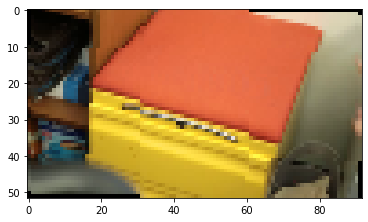

In [13]:
print(video.shape, audio.shape, label.shape)

# plot frame of video
import matplotlib.pyplot as plt
plt.imshow(video[4, 4, :, :, :].cpu().numpy().transpose(1, 2, 0))

# # histogram of video values
# plt.hist(video[4, 0, 0, :, :].cpu().numpy().flatten())
# plt.show()


# Training Loop

In [7]:
from models import VideoAudioMatchingModel2

model = VideoAudioMatchingModel2().to(device)

# train
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-6, weight_decay=1e-4)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = torch.nn.BCELoss()
no_epochs = 15*4
accumulate_gradients = 5  # Number of mini-batches to accumulate gradients over
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Early stopping parameters
patience = 5  # Number of epochs to wait for improvement before stopping
best_val_loss = float('inf')  # Initialize best validation loss
patience_counter = 0  # Initialize patience counter


model.train()
for epoch in range(no_epochs):

    running_loss = 0
    running_corrects = 0
    total_samples = 0


    for batch_idx, (video, audio, label) in enumerate(train_dataloader):
        video = video.to(device)
        audio = audio.to(device)
        label = label.to(device)

        # Forward pass
        outputs = model(video, audio).squeeze()  # (batch_size, 1) -> (batch_size)
        loss = criterion(outputs, label.float())

        # Backward and optimize
        loss.backward()
        running_loss += loss.item()
        total_samples += label.size(0)

        # Calculate accuracy
        predictions = (outputs > 0.5).float()
        running_corrects += (predictions == label.float()).sum().item()

        if (batch_idx + 1) % accumulate_gradients == 0:
            optimizer.step()
            optimizer.zero_grad()
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch + 1, no_epochs, batch_idx + 1, len(train_dataloader), running_loss / (batch_idx + 1)))

    train_losses.append(running_loss / len(train_dataloader))
    train_accuracies.append(running_corrects / total_samples)

    running_val_loss = 0
    running_val_corrects = 0
    total_val_samples = 0

    model.eval()
    with torch.no_grad():
        for batch_idx, (video, audio, label) in enumerate(val_dataloader):

            video = video.to(device)
            audio = audio.to(device)
            label = label.to(device)

            # Forward pass
            outputs = model(video, audio).squeeze()  # (batch_size, 1) -> (batch_size)
            loss = criterion(outputs, label.float())
            running_val_loss += loss.item()
            total_val_samples += label.size(0)

            # Calculate accuracy
            predictions = (outputs > 0.5).float()
            running_val_corrects += (predictions == label.float()).sum().item()

    val_losses.append(running_val_loss / len(val_dataloader))
    val_accuracies.append(running_val_corrects / total_val_samples)

    # print progress
    print('Epoch [{}/{}], Train Loss: {:.4f}, Train Acc: {:.4f}, Val Loss: {:.4f}, Val Acc: {:.4f}'.format(epoch + 1, no_epochs, train_losses[-1], train_accuracies[-1], val_losses[-1], val_accuracies[-1]))

    # Check for early stopping
    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        torch.save(model.state_dict(), 'best_model.pt')  # Save the best model
        patience_counter = 0  # Reset patience counter
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print('Early stopping after {} epochs'.format(epoch + 1))
        break

    model.train()


Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2Model: ['lm_head.weight', 'lm_head.bias']
- This IS expected if you are initializing Wav2Vec2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/60], Step [5/100], Loss: 0.7020
Epoch [1/60], Step [10/100], Loss: 0.6998
Epoch [1/60], Step [15/100], Loss: 0.6934
Epoch [1/60], Step [20/100], Loss: 0.6881
Epoch [1/60], Step [25/100], Loss: 0.6788
Epoch [1/60], Step [30/100], Loss: 0.6817
Epoch [1/60], Step [35/100], Loss: 0.6808
Epoch [1/60], Step [40/100], Loss: 0.6785
Epoch [1/60], Step [45/100], Loss: 0.6775
Epoch [1/60], Step [50/100], Loss: 0.6701
Epoch [1/60], Step [55/100], Loss: 0.6688
Epoch [1/60], Step [60/100], Loss: 0.6690
Epoch [1/60], Step [65/100], Loss: 0.6711
Epoch [1/60], Step [70/100], Loss: 0.6714
Epoch [1/60], Step [75/100], Loss: 0.6624
Epoch [1/60], Step [80/100], Loss: 0.6607
Epoch [1/60], Step [85/100], Loss: 0.6561
Epoch [1/60], Step [90/100], Loss: 0.6486
Epoch [1/60], Step [95/100], Loss: 0.6446
Epoch [1/60], Step [100/100], Loss: 0.6406
Epoch [1/60], Train Loss: 0.6406, Train Acc: 0.6075, Val Loss: 0.9067, Val Acc: 0.2959
Epoch [2/60], Step [5/100], Loss: 0.6284
Epoch [2/60], Step [10/100], Los

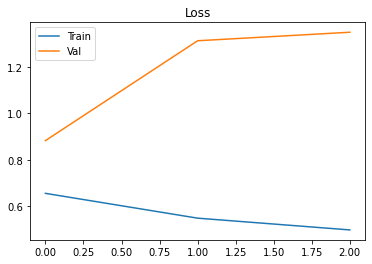

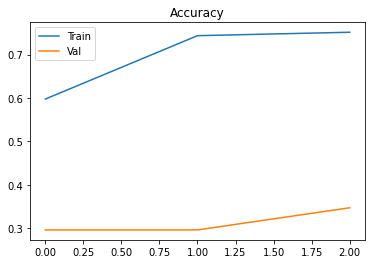

In [ ]:
from matplotlib import pyplot as plt

plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Val')
plt.title('Loss')
plt.legend()
plt.show()

plt.plot(train_accuracies, label='Train')
plt.plot(val_accuracies, label='Val')
plt.title('Accuracy')
plt.legend()
plt.show()


# Test set

In [22]:
from tqdm import tqdm

# load best model
model.load_state_dict(torch.load('best_model.pt'))

<All keys matched successfully>

In [24]:
test_dataset = np.load('datasets/test_dataset.npy')
transforms = [VATransform.RANDOM_SEGMENT,
                    VATransform.IMG_DOWNSAMPLE,
                    VATransform.FRAME_DOWNSAMPLE,
]
test_dataset_cls = VideoAudioDataset(test_dataset, device, filepath_prefix=filepath, transform=transforms, **transform_args)

test_dataloader = DataLoader(test_dataset_cls, batch_size=1, shuffle=False)

model.eval()  # switch model to the evaluation mode
test_predictions = []
test_labels = []
with torch.no_grad():  # deactivate autograd engine to reduce memory usage and speed up computations
    for idx, (video, audio, label) in tqdm(enumerate(test_dataloader)):
        video = video.to(device)
        audio = audio.to(device)
        output = model(video, audio)  # predict
        output = (output > 0.5).float()  # apply threshold
        test_predictions.extend(output.cpu().numpy())
        test_labels.extend(label.numpy())

        # print('Test [{}/{}]'.format(idx + 1, len(test_dataloader)))


98it [00:17,  5.73it/s]


In [25]:
# accuracy
test_predictions = np.array(test_predictions)
test_labels = np.array(test_labels)
test_accuracy = (test_predictions.squeeze() == test_labels.squeeze()).sum() / len(test_labels.squeeze())
print('Test accuracy: {:.4f}'.format(test_accuracy))
print(test_predictions.squeeze())
print(test_labels.squeeze())


Test accuracy: 0.4898
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[1 1 1 1 1 1 0 0 0 0 1 1 0 0 0 1 1 1 0 0 0 1 1 1 0 0 1 0 1 1 0 0 0 0 0 1 0
 0 1 0 0 0 0 1 0 1 1 1 0 1 0 0 1 1 1 0 1 1 0 0 1 1 0 1 1 0 0 1 0 0 0 1 0 1
 1 1 0 0 1 0 0 1 0 0 1 0 0 1 1 1 0 1 1 1 1 1 0 0]


In [29]:
sum(test_predictions.squeeze() == test_labels.squeeze()) / len(test_labels.squeeze())

0.4897959183673469